<a href="https://colab.research.google.com/github/TonyChennn/NLP-NEWS/blob/main/NLP_NEWS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Your name and studend ID should appear here.
## Yun-Han Hsu 47285419

In [ ]:
#Use this cell to import all the required libraries.
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,cross_val_score
import lightgbm as lgb
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from wordcloud import WordCloud
from textblob import TextBlob

In [ ]:
#your work should only start with the following code
df=pd.read_excel("Assignment_Data.xlsx")

#### <font color="red"> When you are preparing your assignment, you can use as many cells as you want. However, before submitting, please ensure that you consolidate all the necessary codes for each section into a single cell according to the template requirements. Failing to follow the template will lead to a loss of marks.

# Data exploration

#### Finding  1:
user_following and user_country have a high number of missing values.

#### Solution 1:
I remove these two columns becaouse it is not appropriate to fill in the mean or mode.

#### Finding  2:
the rest of the feature(columns) only have few missing values. they all just account for 3% of all dataset.

#### Solution 2:
drop them all and reset the index.

#### heatmap for data exploration :

To be honest,just see for the last-left line and the bottom line I want to see does these features have any strong correlation between misinformation.However, there is no significant impacts to misinformation.


      news_author                                      news_headline  \
0    Jill Terreri  New York has passed "the best paid family leav...   
1  Madison Czopek  "BUSTED: CDC Inflated COVID Numbers, Accused o...   
2       Dan Clark  Some states hit hardest by opioid deaths "have...   
3       Dan Clark  "When I saw corruption and sexual harassment c...   
4  Ciara O'Rourke  The Eisenhower interstate system requires that...   

                                       related_tweet  post_replies  \
0  .@JoeBiden is now praising Cuomo's accomplishm...           0.0   
1  @MagicJordan702 @Moses13490917 @RagnaEyjadotti...           3.0   
2  @KaatJim @TimFlannery2 Its a growing problem e...           0.0   
3  .@QuinnipiacPoll: By a margin of 51% to 22%, v...           0.0   
4  #fact The Eisenhower interstate system require...           0.0   

   post_retweets  post_favourites  post_quotes  user_followers  \
0              1                0            0         35212.0   
1             

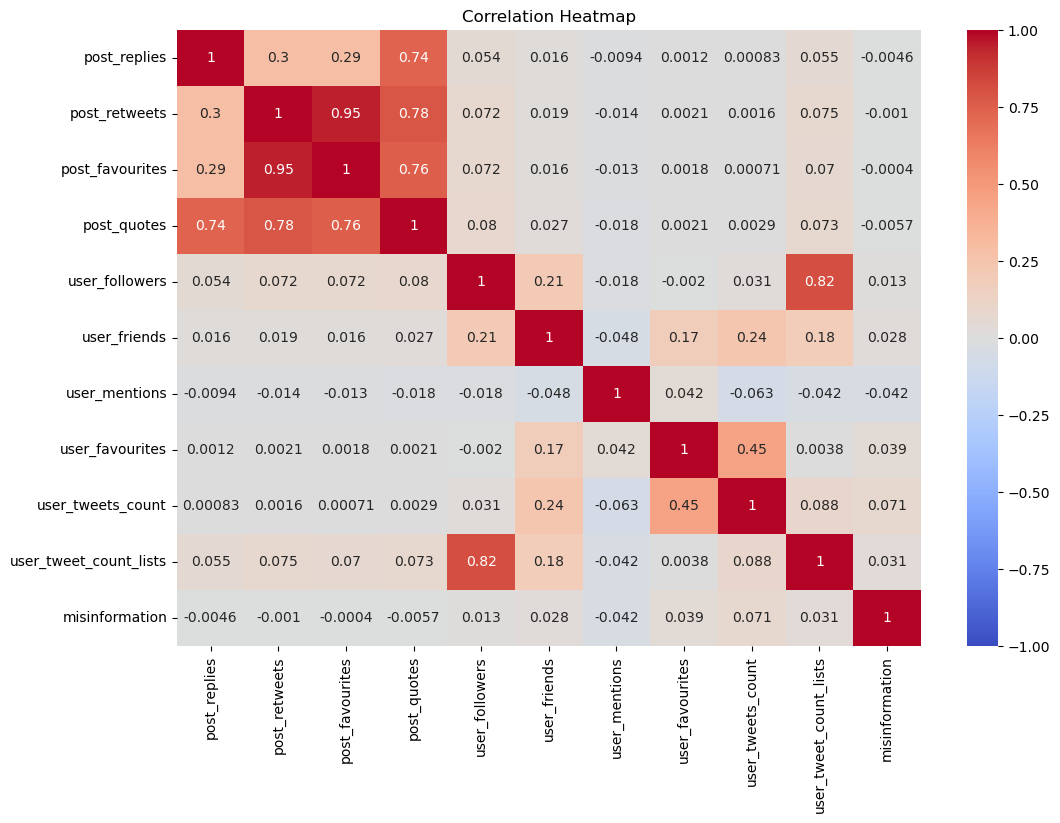

In [ ]:
#Use this cell for data exploration.
print(df.head(),df.isnull().sum(),df.dtypes)
df1 = df.drop(columns = ["user_following","user_country"])
df1.dropna(subset=['misinformation'],inplace = True)
df1 = df1.dropna().reset_index(drop = True)


print ('--------------------------------------------')
print('cleaned')
print(df1.isnull().sum(),df1.head(),df1.dtypes)


corr = df1.corr(numeric_only=True)

# heat map
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

# Text preparation

In this cell,in no more than 150 words, you can elaborate on the the innovativeness and depth of your work on text preparation.

#### NEW 1 :Cleaning Text

Utilized regex to remove non-alphanumeric characters, ensuring only meaningful content remains.
Converted text to lowercase for uniformity, reducing redundancy in word representation.

#### NEW 2 : Removing Stopwords
Employed NLTK's comprehensive English stopword list to filter out common words that do not contribute significant meaning, improving the relevance of the textual data.

#### NEW 3 : remove emails
remove emails signs, like @


Applied these functions sequentially to news_headline and related_tweet columns, ensuring consistency across different text features.

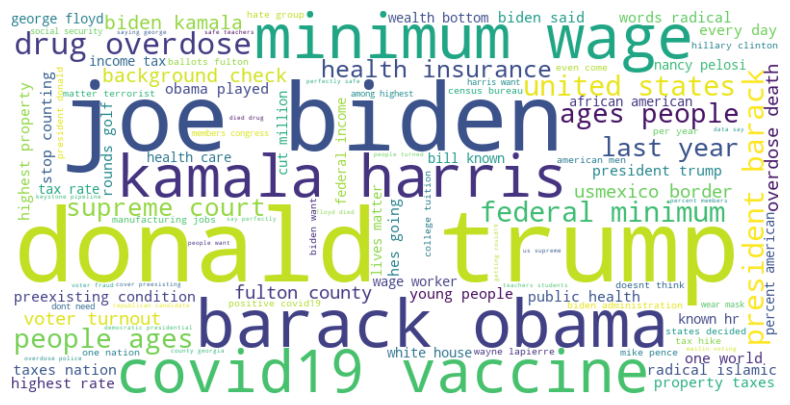

In [ ]:
#Use this cell for text preparation.
# make all the funtions in definition
def clean_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]','',text)
    text = text.lower()
    return text
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    filtered_text = [word for word in words if word not in stop_words]
    return ' '.join(filtered_text)
def remove_emails(text):
    return re.sub(r'\S+@\S+', '', text)

def correct_spelling(text):
    blob = TextBlob(text)
    corrected_text = blob.correct()
    return str(corrected_text)


#Applying
df1['news_headline'] = df1['news_headline'].apply(clean_text).apply(remove_stopwords).apply(remove_emails)
df1['related_tweet'] = df1['related_tweet'].apply(clean_text).apply(remove_stopwords).apply(remove_emails)
df1['news_headline'],len(df1['related_tweet'])
text = "".join(review for review in df1.news_headline)
wordcloud = WordCloud(background_color='white',max_words = 100, width = 800, height = 400).generate(text)
plt.figure(figsize=(10,5))
plt.imshow(wordcloud,interpolation = 'bilinear')
plt.axis('off')
plt.show()

# Feature engineering

In this cell, in no more than 150 words, you can elaborate on the the innovativeness of your work on feature generation.

#### New 1 -- TF-IDF :
Using TF-IDF, we extracted the top 10 terms with the highest scores from the 'news_headline' column to highlight the most significant words, transforming the headlines into numerical features.

#### New 2 -- PCA:
Applied PCA to reduce the dimensionality of the TF-IDF feature set to 10 principal components, capturing the most important variance in the data while reducing complexity.

#### NEW 3 -- STANDARDIZE
Standardized numerical features from the original dataset to ensure they have a mean of 0 and a standard deviation of 1, improving the performance of machine learning algorithms.


#### NEW 4 -- TEXTBOLB
Computed sentiment polarity for each 'related_tweet' using TextBlob, adding a new feature that quantifies the positive or negative sentiment of the tweets.

### Feature 1 generation - TF-IDF

In [ ]:
#Use this cell for text feature_1 generation.
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(df1['news_headline'])
feature_names = tfidf_vectorizer.get_feature_names_out()
max_vals = tfidf_matrix.max(axis=0).toarray().ravel()
sorted_by_tfidf = max_vals.argsort()
top_n = 10
highest_scores = [(feature_names[i],max_vals[i])for i in sorted_by_tfidf[-top_n:]]
print("Top 10 terms by TF-IDF score:")
for term, score in highest_scores:
    print(f"{term}:{score}")
X1=tfidf_matrix.toarray()

Top 10 terms by TF-IDF score:
typical:0.715114373855955
opioid:0.715430382008883
jihad:0.7164897881422425
arizona:0.7235821679331362
doubled:0.7236586768724286
going:0.7258085480122727
governors:0.729983463488611
representation:0.7365486740021195
posts:0.7437950228945036
signing:0.7965989958164644


### Feature 2 generation -- PCA

In [ ]:
#Use this cell for text feature_N generation.
pca = PCA(n_components = 10)
X = pca.fit_transform(X1)

### Feature 3 generation -- Standardize

In [ ]:
o= StandardScaler()
x_array = np.array(df1.iloc[:,3:-1])
std_x =o.fit_transform(x_array)
std_x

array([[-0.01567052, -0.01394379, -0.01503026, ...,  0.09100405,
         0.06650985,  0.49666273],
       [ 0.00887351, -0.0163999 , -0.01448503, ..., -0.15667831,
        -0.42130525, -0.06295523],
       [-0.01567052, -0.0163999 , -0.01503026, ..., -0.01852959,
        -0.36629251, -0.06756494],
       ...,
       [-0.01567052, -0.0163999 , -0.01503026, ..., -0.47891389,
        -0.37341886, -0.06756494],
       [-0.01567052, -0.0163999 , -0.01503026, ..., -0.43533005,
        -0.40413541, -0.02515567],
       [ 0.00069216, -0.0163999 , -0.0139398 , ..., -0.47592014,
        -0.43317361, -0.06756494]])

### Feature 3 generation -- TextBlob

In [ ]:
df__2 = df1['related_tweet'].apply(lambda x: TextBlob(x).sentiment.polarity)
df__1 = pd.DataFrame(X)
df__3 = pd.DataFrame(std_x)
df = pd.concat([df__1,df__2,df__3],axis = 1)
df

,0,1,2,3,4,5,6,7,8,9,...,0,1,2,3,4,5,6,7,8,9
0,-0.090623,0.029731,-0.115903,-0.042647,-0.103782,-0.128502,0.103040,-0.095480,-0.093232,-0.005510,...,-0.015671,-0.013944,-0.015030,-0.020158,0.054563,0.057348,-0.264169,0.091004,0.066510,0.496663
1,-0.038064,0.028455,-0.005829,-0.073980,0.075328,0.022786,-0.006077,0.009469,0.031047,0.029356,...,0.008874,-0.016400,-0.014485,-0.020158,-0.023593,0.142928,1.774794,-0.156678,-0.421305,-0.062955
2,-0.040216,0.002536,-0.021526,-0.005459,-0.019164,-0.002395,0.004654,-0.002800,0.011919,-0.002315,...,-0.015671,-0.016400,-0.015030,-0.020158,-0.025497,-0.250337,0.415485,-0.018530,-0.366293,-0.067565
3,-0.015052,-0.011100,-0.010668,0.008532,0.003958,0.018936,0.004300,0.008016,-0.006391,-0.017729,...,-0.015671,-0.016400,-0.015030,-0.020158,0.183962,0.009550,-0.264169,-0.463698,-0.254509,0.940116
4,-0.048150,-0.009556,-0.035132,0.011611,-0.003622,-0.038329,-0.021503,-0.018230,-0.024621,-0.008023,...,-0.015671,-0.016400,-0.013395,-0.020158,-0.015902,0.357306,-0.943823,0.363857,0.553592,-0.056502
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133773,0.114264,0.014753,-0.003300,0.535593,0.401876,-0.039054,0.365309,-0.004577,0.036837,0.070264,...,-0.015671,-0.016400,-0.015030,-0.020158,-0.021078,0.138062,-0.943823,-0.476254,-0.324227,-0.032531
133774,0.052693,-0.004580,0.018282,0.051431,0.024835,0.013222,-0.076207,-0.071169,0.001913,0.012584,...,-0.015671,-0.016400,-0.015030,-0.020158,-0.025216,-0.235311,0.415485,0.249629,-0.160255,-0.067565
133775,0.003263,-0.006015,0.013907,0.044868,0.036826,0.004528,-0.116507,0.016888,0.000107,0.022778,...,-0.015671,-0.016400,-0.015030,-0.020158,-0.025549,-0.240749,-0.264169,-0.478914,-0.373419,-0.067565
133776,0.032552,0.000903,0.005266,0.042306,0.015491,0.034385,-0.065107,-0.047730,-0.018831,0.118832,...,-0.015671,-0.016400,-0.015030,-0.020158,-0.020487,-0.093918,-0.943823,-0.435330,-0.404135,-0.025156


# Model building & evaluation
Once you have found the most optimal model, you should only show the model building and evaluation here!

### Development:

First, I tried using Decision Tree and K-Nearest Neighbors (KNN) to build the model, but the accuracy was not as expected. Additionally, I was concerned about the risk of optimization. After doing some research, I discovered the powerful classifier LightGBM.

To be honest, when I first used LightGBM, the accuracy was already quite high. However, to ensure I had the best possible model and parameters, I also utilized GridSearchCV to find the optimal parameters.

### Setting :

### Model :  LightGBM

### best params:
learning_rate': 0.1, 'num_leaves': 70 (using GridSearchCV finding the best params)

### Summary of Evaluation:

#### Confusion Matrix:
the confusion Matrix shows that it had better control with low rates of Type 1 and Type 2 errors, showing that the model effectively discriminates between classes.

#### Accuracy:
The model got really high accuracy (95.57%).This means the model's overall correctness in predictions.

#### F1 Score:
The model also got high F1 score (0.9569) indicates that the model maintains a good balance between precision and recall.

#### Overfitting issue:
by using cross validation, we got Cross-validation scores: [0.95539941 0.95510041 0.95549908 0.95504834 0.95694209].Appenrantly, these four figures are quite stable so we may not need to concern about overfitting issue.




[LightGBM] [Info] Number of positive: 51585, number of negative: 48748
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4714
[LightGBM] [Info] Number of data points in the train set: 100333, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514138 -> initscore=0.056567
[LightGBM] [Info] Start training from score 0.056567
Fitting 5 folds for each of 9 candidates, totalling 45 fits
[LightGBM] [Info] Number of positive: 51585, number of negative: 48748
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002355 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4714
[LightGBM] [Info] Number of data points in the train set: 100333, number of used features: 21
[LightGBM] [Info] [bin

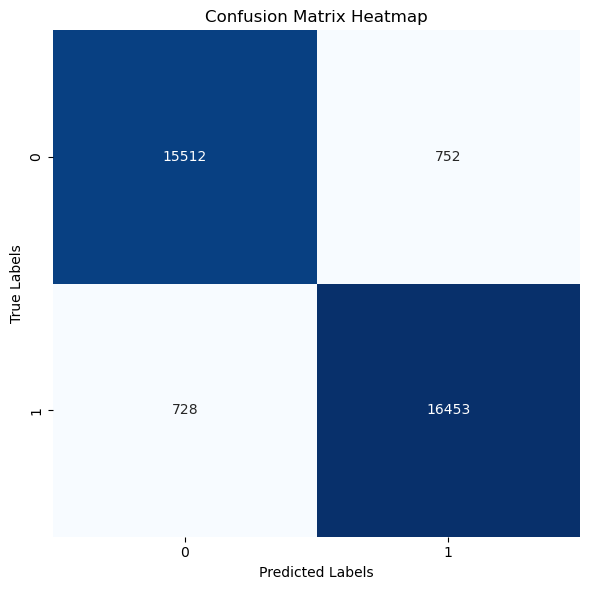

-----------------------------------------------------------------------------------
[LightGBM] [Info] Number of positive: 41268, number of negative: 38998
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.062382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4692
[LightGBM] [Info] Number of data points in the train set: 80266, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514140 -> initscore=0.056577
[LightGBM] [Info] Start training from score 0.056577
[CV] END ..................learning_rate=0.01, num_leaves=31; total time=   6.5s
[LightGBM] [Info] Number of positive: 41268, number of negative: 38998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005004 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4692
[LightGBM] [

[LightGBM] [Info] Number of positive: 41268, number of negative: 38999
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011990 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4706
[LightGBM] [Info] Number of data points in the train set: 80267, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514134 -> initscore=0.056551
[LightGBM] [Info] Start training from score 0.056551
[CV] END ..................learning_rate=0.01, num_leaves=31; total time=   4.3s
[LightGBM] [Info] Number of positive: 41268, number of negative: 38999
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020421 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4706
[LightGBM] [Info] Number of data points in the train set: 80267, number of used features: 21
[Li

[LightGBM] [Info] Number of positive: 41268, number of negative: 38998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012353 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4692
[LightGBM] [Info] Number of data points in the train set: 80266, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.514140 -> initscore=0.056577
[LightGBM] [Info] Start training from score 0.056577
[CV] END ..................learning_rate=0.01, num_leaves=50; total time=   8.1s
[LightGBM] [Info] Number of positive: 41268, number of negative: 38998
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004395 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4703
[LightGBM] [Info] Number of data

In [ ]:
#Use this cell for the best models building & evaluation.
y = df1.iloc[:,-1]
x_tr, x_ts, y_tr, y_ts = train_test_split(np.array(df), y, test_size = 0.25, random_state = 42)
lgb_train = lgb.Dataset(x_tr, label=y_tr)
lgb_eval = lgb.Dataset(x_ts, label=y_ts, reference=lgb_train)
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9
}

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=100,
    valid_sets=lgb_eval
)

# predict
y_pred = gbm.predict(x_ts, num_iteration=gbm.best_iteration)

y_pred = [1 if x > 0.5 else 0 for x in y_pred]

lgbm = lgb.LGBMClassifier()
param_grid = {
    'num_leaves': [31, 50, 70],
    'learning_rate': [0.01, 0.05, 0.1]
}
# using GridSearchCV finding the best params
grid_search = GridSearchCV(estimator=lgbm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(x_tr, y_tr)

best_lgbm = grid_search.best_estimator_
best_lgbm.fit(x_tr, y_tr)

# predict
y_pred = best_lgbm.predict(x_ts)

acc = accuracy_score(y_ts,y_pred)
f1 = f1_score(y_ts,y_pred)
cv_scores = cross_val_score(best_lgbm, x_tr, y_tr, cv=5, scoring='accuracy')

print("---------------------------------------------------------------------------------")
print(f"Mean cross-validation score: {cv_scores.mean():.4f}")
print(f"accuracy:{acc:2f}, F1_score:{f1:2f}")
print(f"Cross-validation scores: {cv_scores}")
# best params
print("best params:", grid_search.best_params_)

## confusion matrix
conf_matrix = confusion_matrix(y_ts, y_pred)
print("confution matrix:")
print(conf_matrix)
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.tight_layout()
##plt.savefig('Confusion Matrix.png')
plt.show()

print('-----------------------------------------------------------------------------------')